#### Error Analysis QA Confidence Score

- Takes 1. QA Model Confidence Scores and 2. Yes/No Mention Status based on the actual label_value.
- Plots a distribution to see the relationship between qa confidence score and mention status.
- The version doesn't matter because the version is just for evaluating with different thresholds, we just need to set one to get the predictions inside.

In [95]:
import re
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from difflib import SequenceMatcher
import os
from transformers import set_seed
import csv 
import numpy as np

# Set the seed
set_seed(42)

# Define the arguments
model_checkpoint = 'franklu/pubmed_bert_squadv2'
model_name = model_checkpoint.split("/")[-1]
model_dir = "../results/trained\\"
model_signature = '_19827_v3\\'
version = 'v1'

desired_fois = ["DCIS Margins", "ER Status", "Extranodal Extension", "HER2 Status", "Insitu Component", "Invasive Carcinoma", "Invasive Carcinoma Margins", "Lymphovascular Invasion", "Necrosis", "PR Status", "Tumour Focality"]
input_dir = os.path.join(model_dir, model_name + model_signature, "eval", version)

In [96]:
def load_all_foi_pred(foi_list, input_dir):
    # Initialize an empty DataFrame that will hold all the concatenated DataFrames
    combined_df = pd.DataFrame()

    for foi in foi_list:
        # Define the path to the CSV file
        file_path = os.path.join(input_dir, foi, 'predictions_' + foi + '.csv')

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Concatenate the DataFrame horizontally with the combined DataFrame
        combined_df = pd.concat([combined_df, df], axis=0)

    return combined_df

combined_df = load_all_foi_pred(desired_fois, input_dir)

In [97]:
# Create the new 'mention' column based on the 'label_value' column
combined_df['mention'] = np.where(combined_df['answer'].isna(), 'No', 'Yes')

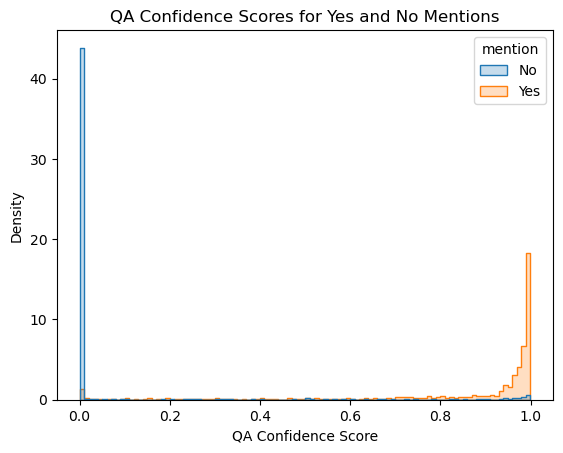

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the plot using seaborn's 'histplot' function with no KDE and high number of bins
sns.histplot(data=combined_df, x='qa_score', hue='mention', element='step', stat='density', kde=False, bins=100)

# Add labels and title
plt.xlabel('QA Confidence Score')
plt.ylabel('Density') # it is divided by the total number of bins
plt.title('QA Confidence Scores for Yes and No Mentions')

# Show the plot
plt.show()



In [99]:
no_mention_df = combined_df[combined_df['mention'] == "No"]
len(no_mention_df[no_mention_df['qa_score'] < 0.1])

834

In [100]:
yes_mention_df = combined_df[combined_df['mention'] == "Yes"]
len(yes_mention_df[yes_mention_df['qa_score'] > 0.1])

938

In [101]:
# algorithim to find the optimal qa_confidence score threshold
import numpy as np

def optimal_qa_score_threshold(df):
    grid_search_qa_scores = np.arange(0, 1, 0.01)
    
    # Initiate optimal qa_score and its corresponding maximum count
    optimal_score = None
    max_count = 0

    output_dir = os.path.join(model_dir, model_name + model_signature, "eval")
    output_filepath = os.path.join(output_dir, 'qa_confidence_score_threshold_analysis.txt')
    with open(output_filepath, 'w') as file:
        for threshold in grid_search_qa_scores:
            # For "No" mention
            no_mention_count = len(df[(df['mention'] == "No") & (df['qa_score'] < threshold)])
            
            # For "Yes" mention
            yes_mention_count = len(df[(df['mention'] == "Yes") & (df['qa_score'] > threshold)])
            
            current_count = no_mention_count + yes_mention_count
            
            if current_count > max_count:
                max_count = current_count
                optimal_score = threshold
            
            log_message = f"The current count is: {current_count} for threshold of {threshold}.\n"
            file.write(log_message)
            print(f"The current count is: {current_count} for threshold of {threshold}.")  # To print it to the console too

    return optimal_score

# Test the function
result = optimal_qa_score_threshold(combined_df)
print(f"The optimal qa_score threshold is: {result}")


The current count is: 977 for threshold of 0.0.
The current count is: 1778 for threshold of 0.01.
The current count is: 1775 for threshold of 0.02.
The current count is: 1774 for threshold of 0.03.
The current count is: 1774 for threshold of 0.04.
The current count is: 1773 for threshold of 0.05.
The current count is: 1774 for threshold of 0.06.
The current count is: 1772 for threshold of 0.07.
The current count is: 1772 for threshold of 0.08.
The current count is: 1772 for threshold of 0.09.
The current count is: 1772 for threshold of 0.1.
The current count is: 1770 for threshold of 0.11.
The current count is: 1770 for threshold of 0.12.
The current count is: 1769 for threshold of 0.13.
The current count is: 1769 for threshold of 0.14.
The current count is: 1768 for threshold of 0.15.
The current count is: 1765 for threshold of 0.16.
The current count is: 1765 for threshold of 0.17.
The current count is: 1764 for threshold of 0.18.
The current count is: 1765 for threshold of 0.19.
The